In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import (print_function, division, absolute_import)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Introduction to Tensorflow 

## Preface
Data engineering makes up for most of the hard work around machine learning. Although we're not attempting to do the data scientists' jobs here, we still need to understand what they're doing to be able to support them best. That's why we'll touch machine learning concepts here. Deliberately, I'll be using *gradient descent* without explaining it. You'll hear about that in later lectures on the subject. What matters here is  that it teaches us about the advanced capabilities available in the chosen technology stack and it provides us a use case that's interesting enough to experience the fun in data engineering.

In part II, I'll be getting into some *feature engineering*, which lives in the border area between machine learning and data engineering.

# Part I: A toy problem
![Baking Powder Machine](../images/baking-powder-packing-machine-500x500.jpg)

Let's assume we are responsible for a machine that produces a particular powder ingredient for baking. And we found it little surprising to hear that the quality of the output depends on the humidity within the last inches of the output pipe. Indeed, at certain humidity levels the probability of the product clumping together or sticking to the pipe increased. It's our job to find out what to do. 

The machine we're talking about has two technical and somewhat mysterious parameters $\beta_1$ and $\beta_2$ that can be measured and tuned. We suspect that the humidity is somehow influenced by these parameters and you are supposed to prove it now. 

A reasonable first hypothesis could be written in mathematical terms as:

$$
h= A_1 \cdot \beta_1 + A_2 \cdot \beta_2 + C
$$

where $h$ is the measured humidity, and $A_1, A_2$ and $C$ are three model parameters that we need to compute now. Any non-zero value for $A_1, A_2$ will confirm our suspicion.

Here's how we take some measurements. Note that we also recorded the weekday and the hour of the day when the measurement took place. At this point in time we consider them irrelevant. In the second part of this exercise though, we'll see that they can actually be meaningfully included in the analysis.

### Data first

```measure(N) ``` creates a [pandas](https://pandas.pydata.org/) data frame with $N$ measurement records in it.

In [4]:
from measurements import measure

In [5]:
data = measure(5)
data.head()

,beta1,beta2,hour,humidity,weekday
0,-2.934153,0.525393,15,9.692765,6
1,0.664185,-1.752306,9,19.878666,1
2,-4.870591,-2.434381,4,10.451214,6
3,-4.387293,-1.919218,8,8.228384,6
4,2.174449,-2.257414,6,23.974719,5


In [6]:
data = measure(10000)
data.describe()

,beta1,beta2,hour,humidity,weekday
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.008913,0.009768,11.448700,19.330172,2.959900
std,2.898888,2.906414,6.893281,6.606501,2.014323
min,-4.998291,-4.999729,0.000000,3.633644,0.000000
25%,-2.525527,-2.532922,5.000000,14.007454,1.000000
50%,-0.003362,0.034413,11.000000,19.367726,3.000000
75%,2.506123,2.527400,17.000000,24.310206,5.000000
max,4.998709,4.999378,23.000000,40.206758,6.000000


### First Evidence for correlation
Scatter plots are easily created with pandas. We can see that $\beta_1$ has a strong correlation with the humidity and it also exhibits a particularly unusual distribution, as the field has a sharper lower edge. We'll be investigating this in part II of this exercise. With $\beta_2$, there might indeed be a very weak negative correlation, but we can't be certain.

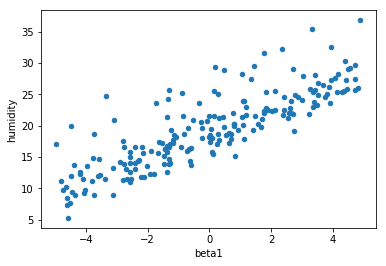

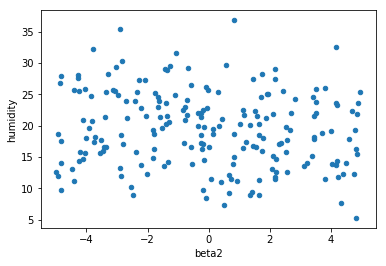

In [7]:
data = measure(200)
data.plot.scatter(x='beta1', y='humidity')
data.plot.scatter(x='beta2', y='humidity');

### Working with tensors

In Tensorflow, everything is a tensor. A number is a rank-0 tensor - sometimes code-named *scalar*, A vector is a rank-1 tensor, a matrix is a rank-2 tensor and all higher-ranked tensors are just rank-n tensors.

Now, we'll make the hypothesis that the correlations can be described by an *affine* function of those technical parameters $\beta_1$ and $\beta_2$. We simply encode this hypothesis using matrix multiplication:

$$
h(\beta_1, \beta_2) = (A_1, A_2) \cdot
\left( 
\begin {array} {c}
\beta_1 \\
\beta_2
\end{array}
\right) + C
$$

which is equivalent to saying:

$$
h(\beta_1, \beta_2) = A_1 \beta_1 +  A_2 \beta_2 + C
$$

Now all that's left is trying to find $A_1, A_2$ and $C$ such that the above function $h$ best reproduces the actually performed measurements for the humidity.

In [1]:
import tensorflow as tf

```tf.Variable```s are those tensors that are meant to be tuned during an optimization process. Since we want to tweak and tune $A_1, A_2$ and $C$, we create variables for those.

In [2]:
# A 1x2 tensor (matrix) for the coefficients A_i
# We're starting with arbitrary values
A = tf.Variable([[1., 2.]], name="coefficients_A", dtype=tf.float32) 
A

<tf.Variable 'coefficients_A:0' shape=(1, 2) dtype=float32_ref>

In [3]:
# A scalar tensor for the *bias* C
C = tf.Variable(3., name="bias_C", dtype=tf.float32)
C

<tf.Variable 'bias_C:0' shape=() dtype=float32_ref>

You can actually look into those tensors and inspect their values with the help of a session (just ignore the initializer for the time being):

In [11]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(C.eval())
    print(A.eval())

3.0
[[1. 2.]]


We use ```tf.placeholder```s for the input data and the *labels*. In machine learning, *labels* represent the *true* values. When *labels* are provided, we say that we're doing *supervised learning*. Here, the labels are the true (measured) humidity. And that's what we want the hypothesis to mimic (reproduce). The ```None``` dimension is left open intentionally as it is this dimension that accounts for the number of input records that will be processed at once.

In [12]:
beta = tf.placeholder(shape=(2,None), name="beta", dtype=tf.float32) 
lbls = tf.placeholder(shape=(1,None), name="true_humidity", dtype=tf.float32)  
beta

<tf.Tensor 'beta:0' shape=(2, ?) dtype=float32>

### The hypothesis function as a computational graph

The linear humidity hypothesis ```h``` represents a computational graph that we can actually navigate to see its branches and leaves like demonstrated below. 

You'll read the plus operator in the following expression
```
h = tf.matmul(A, beta) + C
```
as: take the tensor to the left, attach it to the left of a "+" node, then take the tensor to the right (C) and attach it to the right side of that node. Return the "+" node and with it the attached computational graph.

```
h=
         +
      /    \ 
 matmul      C
 /    \
A     beta
```

In [13]:
h = tf.matmul(A, beta) + C
# h represents the + operation: the root of the tree
print(h)
print()

# The matmul operation is the first input of the + operator
print(h.op.inputs[0])
print()

# The coefficients A to the left of the matmul operation:
print(h.op.inputs[0].op.inputs[0])
print()

# The input beta to the left of the matmul operation:
print(h.op.inputs[0].op.inputs[1])

Tensor("add:0", shape=(1, ?), dtype=float32)

Tensor("MatMul:0", shape=(1, ?), dtype=float32)

Tensor("coefficients_A/read:0", shape=(1, 2), dtype=float32)

Tensor("beta:0", shape=(2, ?), dtype=float32)


---


#### Evaluating the graph

We use a Tensorflow session object to evaluate the computational graph at the particular values given by ```beta_input```

In [14]:
beta_input = [list(data['beta1']), list(data['beta2'])]

In [15]:
beta_input[0][:5]

[3.37896032109572,
 -1.7952036255129213,
 1.0523248390808941,
 -2.554670791023974,
 2.563154767316833]

#### Executing the hypothesis
It's always the same: Initialize all variables and then run the session with the desired tensor node (or a list of tensors). The graph will then resolve the dependencies transitively, compute those and work back to the root where the final result is then computed and passed as a regular number or numpy array. Resolving the placeholders required us to provide some input, which we did using the so-called ```feed_dict```. 

In [16]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    model_humidity = session.run(h, feed_dict={beta: beta_input })

In [17]:
true_humidity = list(data['humidity'])
true_humidity[:5]

[22.992583295145774,
 12.282233673083342,
 21.38454283606272,
 11.46120732225369,
 21.197174866986284]

In [18]:
list(zip(true_humidity, list(model_humidity.squeeze())))[:5]

[(22.992583295145774, 3.0364575),
 (12.282233673083342, 10.018196),
 (21.38454283606272, 0.8544698),
 (11.46120732225369, 4.778757),
 (21.197174866986284, 9.328702)]

The results differ vastly from the true humidity - unsurprisingly so - we haven't tuned the parameters $A$ and $C$ yet.  

#### Delegating execution specifics to the session
Note that the complexity seen above makes sense because once the graph is constructed it's up to the Tensorflow runtime to find out how to compute the results in the most efficient way, taking also the available advanced system resources, such as GPUs or TPUs into account. You as a developer need not bother, just pass your graph to the session.

#### All input in one go
Note also that all the records will processed in a single go. There is no loop over the input data. Indeed all the input data forms a single $N \times 2$ matrix with $N$ being the number of samples. That makes computation truly efficient, as GPUs and TPUs can perform thousands of mathematical operations in parallel, and there's no forth and back between the Python script interpreter and the underlying computational infrastructure.

#### Error = Distance between model and reality

We want the model humidity to be as close as possible to the *true* humidity. To achieve that we need to measure how close the model has come to the true humidity. The mean squared error is a good candidate for that purpose, and we'll use the placeholder ```lbls``` ('labels' is commonly used in machine learning) that we introduced previously to represent the true humidity.

In [19]:
msq_error = tf.losses.mean_squared_error(h,lbls)

# We need to fit the shape to the hypothesis input placeholder
true_humidity = [true_humidity] 

Instructions for updating:
Use tf.cast instead.


In [20]:
with tf.Session() as session:
    session.run(init)
    error = session.run(msq_error, 
                        feed_dict={
                            beta: beta_input, 
                            lbls: true_humidity })
print(error)

337.13812


#### Tuning the parameters

*Note: We'll use some advanced concepts that we can't cover to the full extent here. Please refer to any of the quazillions of amazing introductory sources available on the internet to get familiar with the concept of gradient descent. [This video by 3Blue1Brown talks about gradient descent in the concept of neural networks, but still it's super-easy to grasp because of its amazing visualizations](https://www.youtube.com/watch?v=IHZwWFHWa-w&t=1s)*.

The *gradient* is a measure of how much the value of a function changes, when its input changes infinitesimaly. If e.g. the gradient of the distance with respect to $A_1$ is positive then that means making $A_1$ a bit smaller would also make the distance smaller. And that's exactly what we're trying to achieve. So what we'll do is iteratively substract a fraction (defined by some small learning rate epsilon $\varepsilon$) of the gradient from the values of $A$ and $B$. And we do this in vector form.

In [21]:
epsilon = 1e-2

In [22]:
grad_A = tf.gradients(msq_error, A)
grad_C = tf.gradients(msq_error, C)

Note how easy it is to calculate gradients here. It's all built into the framework. That's super-easy here, because the computational graph allows the computation of any derivative from basic principles according to the rules that we all (should've) learned in our calculus classes.

In [23]:
Tune_A = tf.assign_add( A, tf.multiply(grad_A[0], -epsilon))
Tune_C = tf.assign_add( C, tf.multiply(grad_C[0], -epsilon))

In mathematical terms, what we do is:
$$
A \leftarrow A - \varepsilon \cdot \frac{\partial}{\partial A} \text{MSE}
$$

$$
C \leftarrow C - \varepsilon \cdot \frac{\partial}{\partial C} \text{MSE}
$$

with MSE being the mean squared error ```msq_error```. Computationally, evaluating ```Tune_A``` will have the *side effect* of changing the value of variable ```A``` and ```Tune_C``` will do that with ```C```.

We create some independent test data

In [24]:
test_data = measure(20)
test_true = [list(test_data['humidity'])]
test_beta = [list(test_data['beta1']), list(test_data['beta2'])]

...and the data that we use for the optimization process:

In [25]:
data = measure(10000)
true_humidity = [list(data['humidity'])]
beta_input = [list(data['beta1']), list(data['beta2'])]

Note that the below implementation is deliberately simple and a little inefficient to keep things more readable. The code cell below computes the gradients and adjusts the parameters 200 times and spits out a list of all values for ```msq_error```. 

In [26]:
errors = []
with tf.Session() as session:
    session.run(init)
    for count in range(200):
        
        # compute the current error/distance
        error = session.run(msq_error, feed_dict={
            beta: beta_input, 
            lbls: true_humidity 
        })
        errors.append(error)
        
        # tune and tweak the parameters a little
        session.run([Tune_A, Tune_C], feed_dict={
            beta: beta_input, 
            lbls: true_humidity 
        })

    # Storing test results and parameters
    test_results, a, c = session.run([h, A, C], feed_dict={
        beta: test_beta})
        
print(errors)

[336.9973, 307.5505, 284.35712, 265.59354, 249.9965, 236.68985, 225.06477, 214.69695, 205.28978, 196.63481, 188.58469, 181.03424, 173.90767, 167.1495, 160.71846, 154.58316, 148.71918, 143.10696, 137.73053, 132.57626, 127.63256, 122.88914, 118.33656, 113.9664, 109.77072, 105.74225, 101.87395, 98.15936, 94.59214, 91.16646, 87.876564, 84.71705, 81.68275, 78.76864, 75.96995, 73.28213, 70.700745, 68.22159, 65.84063, 63.553925, 61.3578, 59.24865, 57.22301, 55.277588, 53.4092, 51.61481, 49.891464, 48.236355, 46.64679, 45.120186, 43.65402, 42.24593, 40.89358, 39.594784, 38.347424, 37.149464, 35.99892, 34.893944, 33.832733, 32.813538, 31.834713, 30.894638, 29.991787, 29.124687, 28.291925, 27.492144, 26.724031, 25.986332, 25.277842, 24.59741, 23.943922, 23.316315, 22.71356, 22.134668, 21.5787, 21.044758, 20.53195, 20.039448, 19.56645, 19.112185, 18.67591, 18.256908, 17.8545, 17.46802, 17.096842, 16.74037, 16.398018, 16.06921, 15.753434, 15.450163, 15.158894, 14.879161, 14.610501, 14.352478, 14.1

The steadily decreasing list of errors above is a very welcome sign. It means: Our model's output values are indeed getting closer and closer to the *true* humidity. I dare say our model is successfully converging to the *truth*. And we should definitely see that when we explicitly compare true humidity with the one that our model *predicts*.

In [27]:
list(zip(list(test_results[0]), test_true[0]))

[(20.467215, 19.843847467323656),
 (11.759345, 20.768984075027454),
 (20.45511, 18.086374854606117),
 (21.893688, 22.41534145869465),
 (8.62908, 10.052839541670705),
 (13.399155, 9.807403175878358),
 (9.57982, 9.026562159766183),
 (25.593264, 26.943128060819557),
 (15.052731, 13.797008563869138),
 (18.269175, 26.227160468188448),
 (21.453953, 19.05655305039198),
 (24.381725, 22.412831131811632),
 (19.097748, 28.349013304821256),
 (17.498976, 24.8591308737222),
 (12.114513, 10.170436868726863),
 (23.116415, 30.21926877388465),
 (11.039659, 11.12909543639891),
 (12.926331, 13.34951819873351),
 (13.672737, 11.233274754233777),
 (24.669544, 26.722786147589755)]


The parameters $A_1, A_2$ and $C$ have eventually converged to:

In [28]:
list(a[0]), c

([1.9875296, -0.5153014], 19.082794)

That concludes the first part of this exercise. You learned to construct and execute computational graphs with Tensorflow and apply one of the most fundamental techniques, namely gradient descent to solve an analytical problem. 

---

# Part II: Feature Engineering

So, are we happy? To a large degree we could indeed be. We have found convincing evidence that those
mysterious parameters indeed have some influence on the humidity, so tuning them appropriately may help overcome the afforementioned problems. Yet, we began to suspect that something else is wrong. To provide some more evidence, let's have a look at the distribution of the errors over a larger data set.


In the following context, we'll be working with the parameters $A_1, A_2, B$ that we've found previously and thus make them constants. For $10000$ measurements we record how far we have predicted from the measured humidity.

In [29]:
data = measure(10000)
true_humidity = [list(data['humidity'])]
beta_input = [list(data['beta1']), list(data['beta2'])]

A = tf.constant([2, -.5], shape=(1,2), dtype=tf.float32)
C = tf.constant(18.5, shape=(), dtype=tf.float32)
h = tf.matmul(A, beta) + C
error = (h-lbls)
with tf.Session() as session:
    errors1 = session.run(
        error, feed_dict={beta: beta_input, lbls: true_humidity})

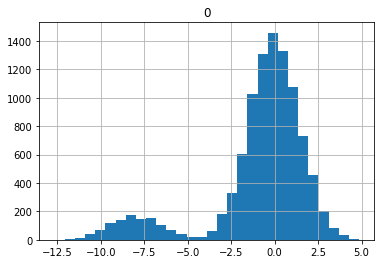

In [30]:
pd.DataFrame(errors1[0]).hist(bins=30);

What a surprise! Error distributions of that kind indicate that the linear model is overlooking something. It appears ok for the majority of measurements (the big peak around 0), but a small subset of measurements is apparently influenced by still unknown forces. 

Now, how to approach that problem? At the moment, we're only considering $\beta_1$ and $\beta_2$ as influence factors. Maybe there are other factors. Maybe on certain days or at certain times of the day the humidity is influenced by other events?


In [31]:
import seaborn as sns
sns.set()
data = measure(2000)

```seaborn``` introduces a convenience layer on top of matplotlib using pandas under the hood. It's extremely helpful for quick explorations.

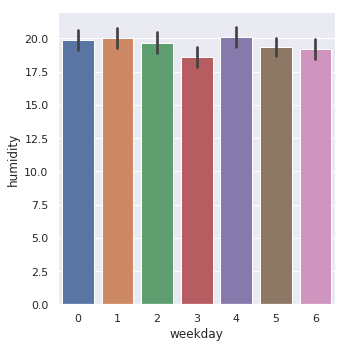

In [32]:
sns.catplot(x='weekday', y='humidity', kind='bar', data=data);

Look at the average humidity for each day of the week. Still hard to say. Thursdays and Sundays appear particularly low. But do we have sufficient statistics to conclude? Let's have a look at the hours of the day:

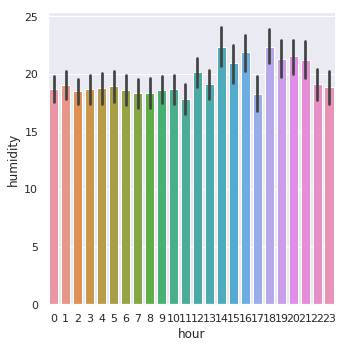

In [33]:
sns.catplot(x='hour', y='humidity', kind='bar', data=data);

The error bars are not big enough to dismiss the differences as statistical noise. So we're getting closer. But still it's not easy to tell what's really going on. 

*(Hint: Don't be shy to look at the statistics of 50'000 data points)*

Well, here we are. It's obvious that we need to take weekdays and hours of day into account. But that's not so trivial. While $\beta_1$ and $\beta_2$ were suspected to influence the humidity somewhat linearly, that is certainly not true for hour and weekday. Data engineering has the answer: *one-hot* encoding. That's almost always a successful strategy, if it is somehow a *yes-or-no* or a *one-in-N* aspect that governs the problem.

---
# The full solution
#### One-Hot encoding weekdays and hours 

We use a neat combination of Python tricks to one-hot encode a number: The $n$-th column (or row) vector of the identity matrix (```np.eye``` in the numpy world), is the one-hot encoding for $n$:

In [34]:
ID = np.eye(7)
ID

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [35]:
for n in [0, 3, 6]:
    print("%s -> %s" % (n, ID[n]))

0 -> [1. 0. 0. 0. 0. 0. 0.]
3 -> [0. 0. 0. 1. 0. 0. 0.]
6 -> [0. 0. 0. 0. 0. 0. 1.]


You see the $1$s at the position given by the index. So, Monday would be represented by the first vector, Thu by the second and Sun by the third.

Here comes the even cooler trick: We can use an array of indices rather than single indices one by one:

In [36]:
indices = [0,3,6]
ID[indices]

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

See: All three days one-hot-encoded in a single go

#### Feature Crossing
Now to be truly indicative of the very hour within a week, we will introduce the hour-of-the-week features, which we get by the outer product of one-hot encoded week days and hours of the day. Let's look at Thu 12:00.

Note that we expand the dimensions to include an extra empty dimension. That's required for python ```*``` operator to understand that we want the outer product.

In [37]:
thu = np.expand_dims(np.eye(7)[3], -1)
thu

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [38]:
at12 = np.expand_dims(np.eye(24)[12], -1)
at12.T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [39]:
thu * at12.T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

You can see that there's only one number set: That's exactly Thursdays at 12:00. Now let's do that for a larger dataset using a flat representation: a vector of 168 weekly hours

In [40]:
n_train = 10
data = measure(n_train)
true_humidity = [data['humidity']]

weekday = np.array(data['weekday'])
hour = np.array(data['hour'])

hour_of_week = weekday*24+hour

# hour-of-week one-hot encoded
howoh = np.eye(7*24)[hour_of_week]

howoh[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
true_humidity

[0    28.269846
 1    21.980044
 2    17.734114
 3    15.253020
 4    23.520104
 5    18.816634
 6    25.387625
 7    22.437577
 8    23.955003
 9    13.605414
 Name: humidity, dtype: float64]

In [42]:
np.shape(true_humidity)

(1, 10)

In [43]:
np.array([data['beta1']]).shape, howoh.T.shape

((1, 10), (168, 10))

Now stack 'em all together to arrive at the full one-hot feature-crossed input samples

In [44]:
all_input = np.vstack([[data['beta1']], [data['beta2']], howoh.T])
all_input.shape

(170, 10)

#### A complete input sample - pretty sparse

In [45]:
all_input.T[0]

array([ 3.90142015, -1.87104164,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

#### Putting it all together

In [46]:
def create_data(N):
    data = measure(N)
    true_humidity = [data['humidity']]

    weekday = np.array(data['weekday'])
    hour = np.array(data['hour'])

    hour_of_week = weekday*24+hour

    # hour-of-week one-hot encoded
    howoh = np.eye(7*24)[hour_of_week]

    all_input = np.vstack([[data['beta1']], [data['beta2']], howoh.T])    
    
    return all_input, true_humidity

In [47]:
# just checking:
inp, outp = create_data(1)
inp.T, outp

(array([[-3.13095687, -2.32995175,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.

In [48]:
all_input, true_humidity = create_data(10000)
test_input, test_true = create_data(100)

In [49]:
#    Your turn
#
# A 1x170 tensor (matrix) for the coefficients A_i
# Start with uniformly distributed random values 0 < r < 1
A = tf.Variable(np.random.uniform(size = [1, 170]), 
                name="coefficients_A", dtype=tf.float32) 
A

<tf.Variable 'coefficients_A_1:0' shape=(1, 170) dtype=float32_ref>

In [50]:
#    Nothing new here
#
# A scalar tensor for the *bias* C
C = tf.Variable(3., name="bias_C", dtype=tf.float32)
C

<tf.Variable 'bias_C_1:0' shape=() dtype=float32_ref>

In [51]:
#
#  Placeholders shape=(9, None) for input data, (1, None) for labels
#
input_placeholder = tf.placeholder(
    shape=(170,None), name="all_input", dtype=tf.float32) 
labels_placeholder = tf.placeholder(
    shape=(1,None), name="true_humidity", dtype=tf.float32)  
input_placeholder

<tf.Tensor 'all_input:0' shape=(170, ?) dtype=float32>

In [52]:
#    Thanks to the vector notation, the hypothesis function doesn't 
#    change
#
h = tf.matmul(A, input_placeholder) + C
h

<tf.Tensor 'add_2:0' shape=(1, ?) dtype=float32>

In [53]:
#
#   Mean squared error: Nothing changes here
#
msq_error = tf.losses.mean_squared_error(h,labels_placeholder)
msq_error

<tf.Tensor 'mean_squared_error_1/value:0' shape=() dtype=float32>

In [54]:
#
#   gradients and updating: Nothing changes here
#
epsilon=1e-1
grad_A = tf.gradients(msq_error, A)
grad_C = tf.gradients(msq_error, C)
Tune_A = tf.assign_add( A, tf.multiply(grad_A[0], -epsilon))
Tune_C = tf.assign_add( C, tf.multiply(grad_C[0], -epsilon))
Tune_A

<tf.Tensor 'AssignAdd_2:0' shape=(1, 170) dtype=float32_ref>

### Full training
This code cell will take a while. It will run the entire training set 5000 times, reporting the current loss every after 250 epochs. That means that you'll see it report 20 different losses - decreasing steadily.

In [55]:
errors = []
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for count in range(5000):
        
        # compute the current error/distance
        error = session.run(msq_error, feed_dict={
            input_placeholder: all_input, 
            labels_placeholder: true_humidity 
        })
        if count % 250 == 0:
            print(error)
        
        # tune and tweak the parameters a little
        session.run([Tune_A, Tune_C], feed_dict={
            input_placeholder: all_input, 
            labels_placeholder: true_humidity 
        })

    # Storing test results and parameters
    test_results, a, c = session.run([h, A, C], feed_dict={
        input_placeholder: test_input})
        

280.56094
5.523085
3.940568
3.0750852
2.598493
2.3342798
2.1868455
2.104053
2.0572782
2.030698
2.0155113
2.0067883
2.0017536
1.9988344
1.9971337
1.9961402
1.9955568
1.995213
1.9950101
1.9948899


The parameter vector A without the $\beta$s has values $a_i > 1$ at those hours where there's something wrong with the humidity. You may want to compare the positions with the evidence that you can get from looking at ```measurements.py```. 

Quintessence: Machine learning allowed us to detect an otherwise hidden pattern: Here it could've been that our machine suffers from the peak hours of the dry cleaner's shop in the first floor. Something typically unexpected.

In [56]:
a[0][2:]

array([-1.75302908e-01, -4.26282644e-01, -1.78176746e-01, -4.22825903e-01,
       -1.91730455e-01, -1.04565956e-01, -3.21831584e-01, -8.96394327e-02,
       -1.77833587e-01, -2.74669737e-01, -4.16929811e-01, -2.28571936e-01,
       -2.11460680e-01, -1.95972264e-01, -2.68589944e-01, -6.56221330e-01,
       -4.87084478e-01, -2.10978255e-01,  7.80231237e+00,  7.50700378e+00,
        7.77310610e+00,  7.45582867e+00, -4.58934993e-01, -2.64592260e-01,
       -3.83154035e-01, -6.63764358e-01, -3.83053452e-01, -1.19235463e-01,
       -1.99675620e-01, -2.71016479e-01, -2.60888804e-02, -4.26095545e-01,
       -1.59648538e-01, -4.05057669e-01, -3.99721742e-01, -2.07652107e-01,
       -7.60285109e-02, -2.45074809e-01, -2.30639771e-01, -3.07917923e-01,
       -4.15447831e-01, -4.05537605e-01,  7.80891228e+00,  7.79755926e+00,
        7.90920019e+00,  7.66469002e+00, -8.73618126e-02, -2.18786672e-01,
       -6.08955562e-01, -8.36880058e-02, -2.69324929e-01, -1.05757296e-01,
       -2.50050902e-01, -

---
Observe that there are hardly any large errors anymore

In [57]:
zip(test_results[0], list(test_true[0]))[:20]

[(17.996853, 18.43711648028375),
 (19.407814, 18.415234933181914),
 (29.392675, 31.748881129260283),
 (27.437958, 25.986194706311835),
 (17.586256, 14.825392235043871),
 (27.003983, 25.377508453615558),
 (13.79144, 13.673172691535255),
 (22.338894, 22.265630891991563),
 (14.210359, 14.112937122535005),
 (24.152489, 26.194956810000846),
 (8.728538, 8.167258845547739),
 (13.344393, 12.616404875890842),
 (23.806852, 23.546030929035975),
 (8.818285, 4.2652793868876495),
 (12.951513, 11.757368196325354),
 (14.907963, 15.159795898551494),
 (36.7603, 35.812801489832566),
 (26.373926, 25.83890808671502),
 (14.960114, 16.827702143365983),
 (24.677618, 24.782932344905213)]

In [58]:
all_input, true_humidity  = create_data(10000)

A = tf.constant(a, shape=(1,170), dtype=tf.float32)
C = tf.constant(c, shape=(), dtype=tf.float32)
h = tf.matmul(A, input_placeholder) + C
error = (h-labels_placeholder)
with tf.Session() as session:
    errors = session.run(
        error, feed_dict={input_placeholder: all_input, labels_placeholder: true_humidity})

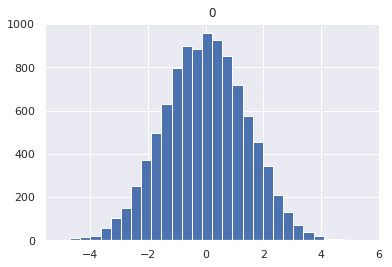

In [59]:
pd.DataFrame(errors[0]).hist(bins=30);

This is a truly satisfactory error pattern: Only statistically explainable errors!

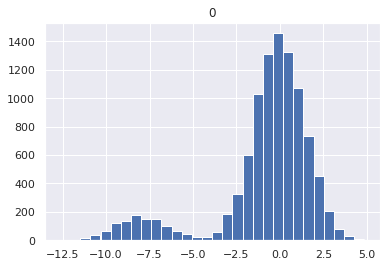

In [60]:
pd.DataFrame(errors1[0]).hist(bins=30);

Remember: That's what we came from, originally!